In [1]:
import cv2
import numpy as np
import os
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from pyefd import elliptic_fourier_descriptors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def read_images_and_extract_contours(folder_path):
    """Read images from a folder and extract their largest external contour."""
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    contours_list = []
    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            contour = max(contours, key=cv2.contourArea)
            contour = contour.squeeze()
            contours_list.append(normalize_contour_points(contour))
    return contours_list

In [4]:
def read_images_and_extract_contours_single_image(img_location):
    """Read images from a folder and extract their largest external contour."""
    images = img_location
    contours_list = []
    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            contour = max(contours, key=cv2.contourArea)
            contour = contour.squeeze()
            contours_list.append(normalize_contour_points(contour))
    return contours_list

In [5]:
def normalize_contour_points(contour):
    """Normalize contour points to a fixed number for consistency."""
    N = 250
    contour_length = np.linspace(0, 1, len(contour))
    normalized_length = np.linspace(0, 1, N)
    interp_func_x = interp1d(contour_length, contour[:, 0], kind='linear')
    interp_func_y = interp1d(contour_length, contour[:, 1], kind='linear')
    normalized_contour = np.vstack((interp_func_x(normalized_length), interp_func_y(normalized_length))).T
    return normalized_contour

def compute_fourier_coefficients(contour, order=30):
    """Compute Fourier coefficients for a given contour."""
    coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=True)
    #return coeffs[1:]  # Skip the first coefficient as it's related to the image position
    return coeffs

def compute_class_averages(fourier_descriptors, labels, n_clusters):
    """Compute average Fourier coefficients for each cluster."""
    sums = [np.zeros(fourier_descriptors[0].shape) for _ in range(n_clusters)]
    counts = [0] * n_clusters
    for coeffs, label in zip(fourier_descriptors, labels):
        sums[label] += coeffs
        counts[label] += 1
    averages = [sums[i] / counts[i] if counts[i] > 0 else None for i in range(n_clusters)]
    return averages

In [6]:
def inverse_fourier_transform(coeffs, num_points=500, H=30):
    """Reconstruct a shape from its Fourier coefficients."""
    X, Y = np.zeros(num_points), np.zeros(num_points)
    t_values = np.linspace(0, 2 * np.pi, num_points, endpoint=True)
    for h in range(H):
        X += coeffs[h, 0] * np.cos((h+1) * t_values) + coeffs[h, 1] * np.sin((h+1) * t_values)
        Y += coeffs[h, 2] * np.cos((h+1) * t_values) + coeffs[h, 3] * np.sin((h+1) * t_values)
    return np.vstack((X, Y)).T

In [14]:
def calculate_iou(contour1, contour2, image_shape):
    """Calculates the Intersection over Union (IoU) between two contours."""
    mask1 = np.zeros(image_shape, np.uint8)
    cv2.drawContours(mask1, [contour1], -1, 255, -1)

    mask2 = np.zeros(image_shape, np.uint8)
    cv2.drawContours(mask2, [contour2], -1, 255, -1)

    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [7]:
def predict_cluster(image_path, kmeans, order=30):
    """Predicts the cluster for a single image and returns its label and average shape."""
    contour = read_images_and_extract_contours_single_image([image_path])[0]
    fourier_coeffs = compute_fourier_coefficients(contour, order=order).flatten()
    cluster_label = kmeans.predict([fourier_coeffs])[0]
    class_averages = compute_class_averages([fourier_coeffs], [cluster_label], kmeans.n_clusters) # Compute the average shape for the cluster
    avg_shape = inverse_fourier_transform(class_averages[cluster_label].reshape(order, -1), H=order) # Reconstruct the average shape
    return cluster_label, avg_shape

In [12]:
def plot_predicted_clusters(predicted_cluster, avg_shape, image_to_predict_path):
    plt.ion()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show the image
    img = cv2.imread(image_to_predict_path)
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Input Image')
    axes[0].axis('off')  # Turn off axis for the image
    
    #Show the average shape of the associated cluster
    axes[1].plot(avg_shape[:, 0], avg_shape[:, 1])
    axes[1].set_title(f'Predicted Cluster: {predicted_cluster + 1}')
    axes[1].axis('equal')
    axes[1].set_aspect('equal')

    plt.show()

In [9]:
def main(folder_path, n_clusters=36, order=30):
    contours = read_images_and_extract_contours(folder_path)
    fourier_descriptors = np.array([compute_fourier_coefficients(c, order=order).flatten() for c in contours])

    if fourier_descriptors.shape[0] > 1:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(fourier_descriptors)
        labels = kmeans.labels_
        class_averages = compute_class_averages(fourier_descriptors, labels, n_clusters)
        
        #Determine subplot grid size
        cols = min(n_clusters, 12)
        rows = n_clusters // cols + (n_clusters % cols > 0)

        # Plot individual clusters in subplots
        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3.75))
        axes = axes.flatten() if n_clusters > 1 else [axes]

        for i, avg_coeffs in enumerate(class_averages):
            if avg_coeffs is not None:
                shape_model = inverse_fourier_transform(avg_coeffs.reshape(order, -1), H=order)
                ax = axes[i]
                ax.plot(shape_model[:, 0], shape_model[:, 1], label=f'Cluster {i + 1}')
                ax.set_title(f'Cluster {i + 1}')
                ax.axis('equal')
                ax.legend()

        # Adjust layout
        plt.tight_layout()
        plt.show()

        # Input the image to predict
        

        while True:
            image_to_predict_path = input("Enter the path to the image you want to predict (or type 'q' to quit): ")
            if image_to_predict_path.lower() == 'q':
                break

            predicted_cluster, avg_shape = predict_cluster(image_to_predict_path, kmeans, order=order)

            # Plot the predicted cluster
            plt.ion()
            plot_predicted_clusters(predicted_cluster, avg_shape, image_to_predict_path)            

    else:
        print("Not enough contours for KMeans clustering.")

/opt/miniconda3/envs/potatot/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


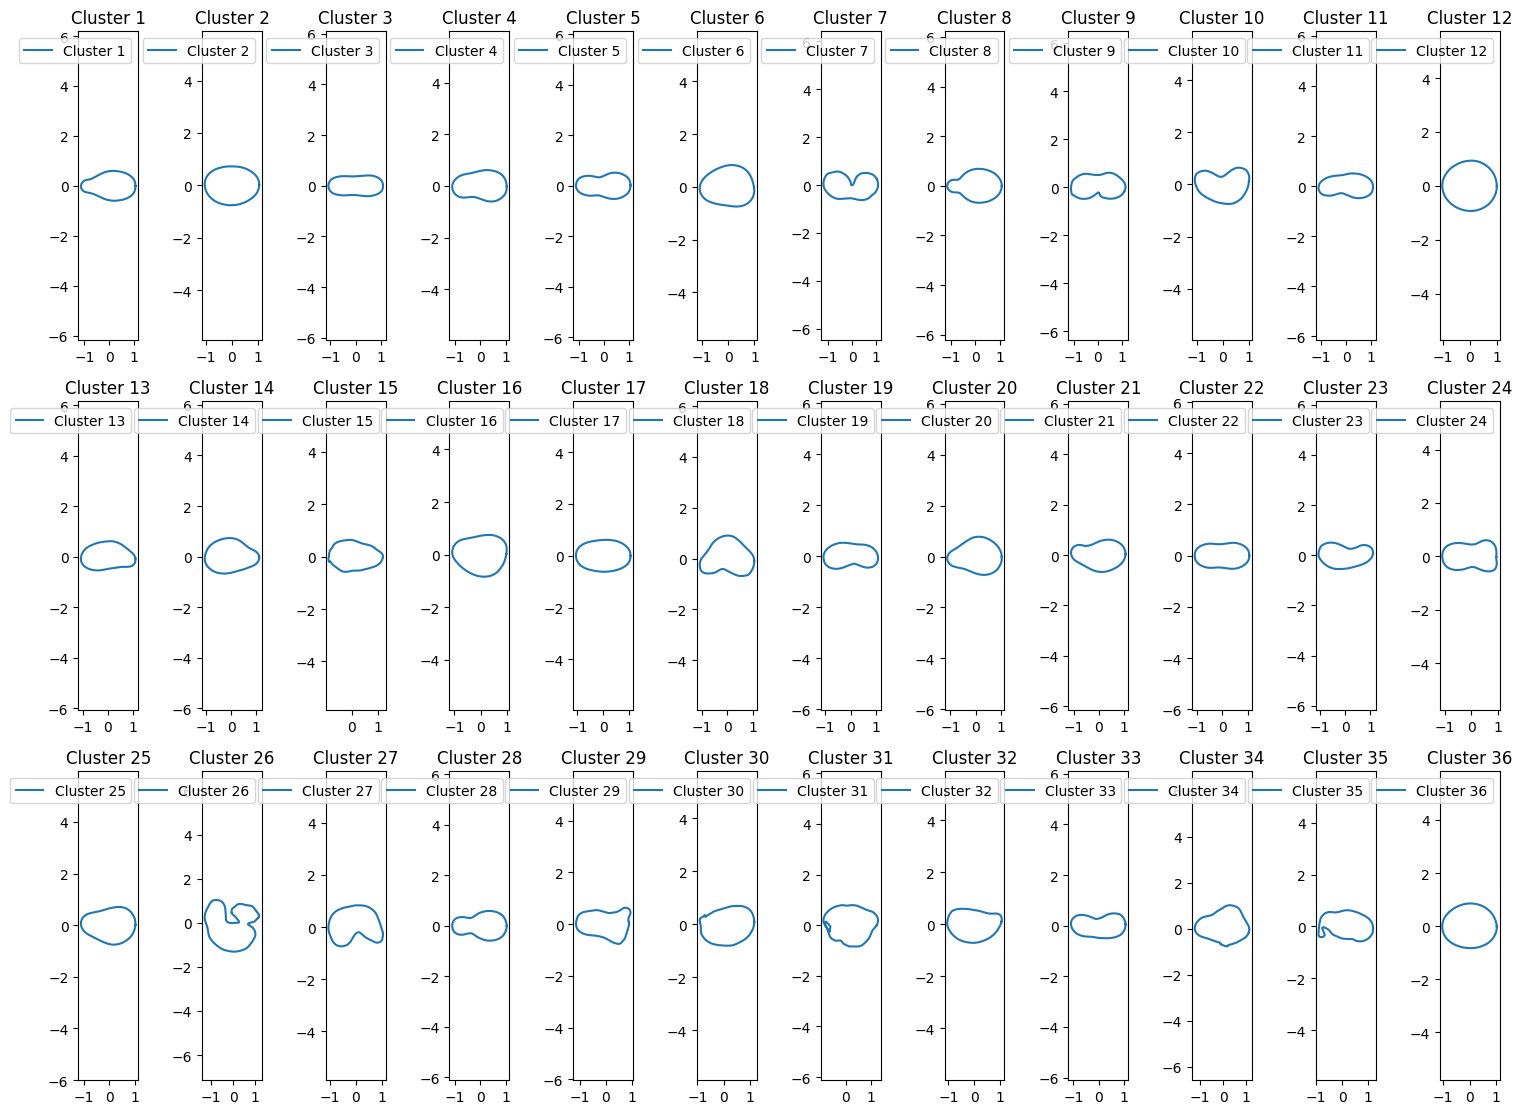

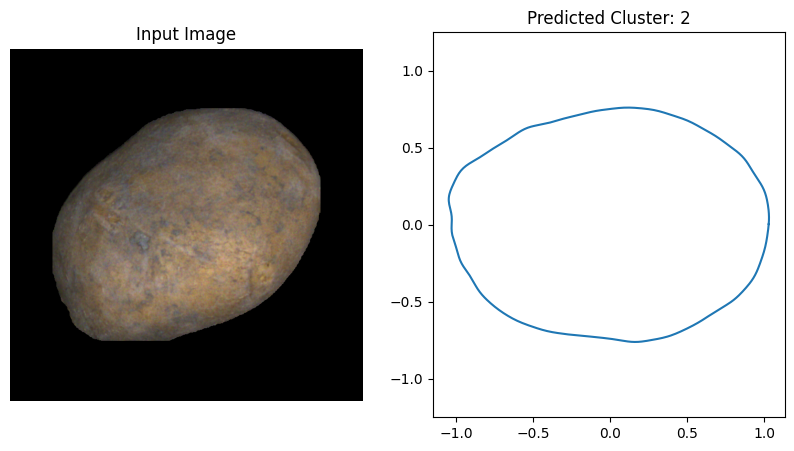

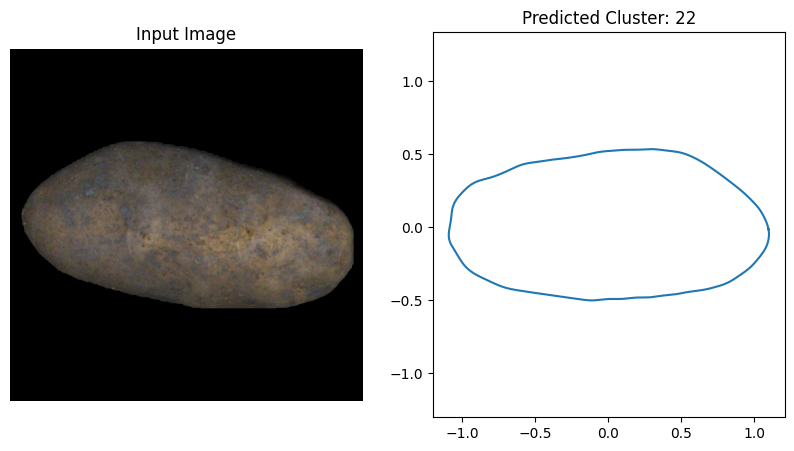

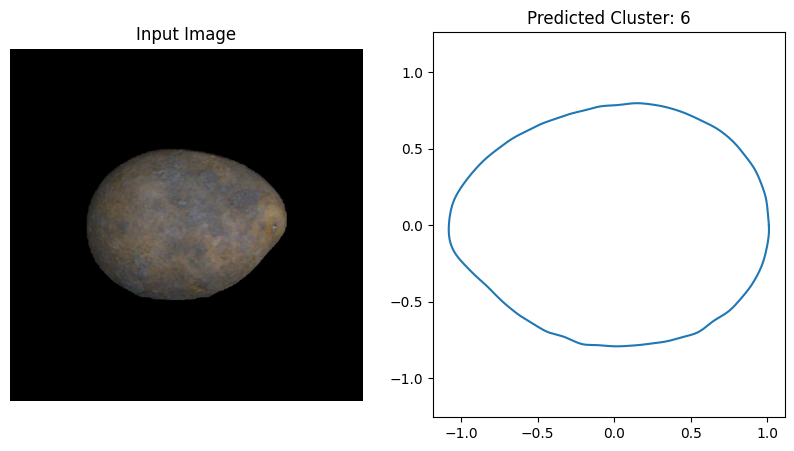

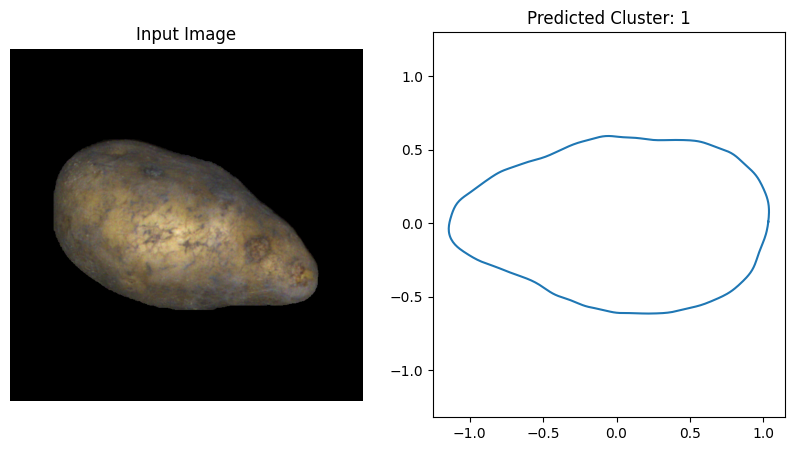

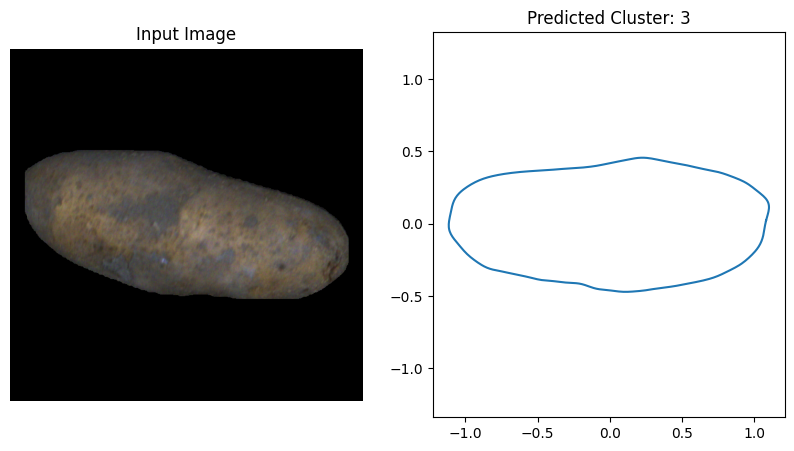

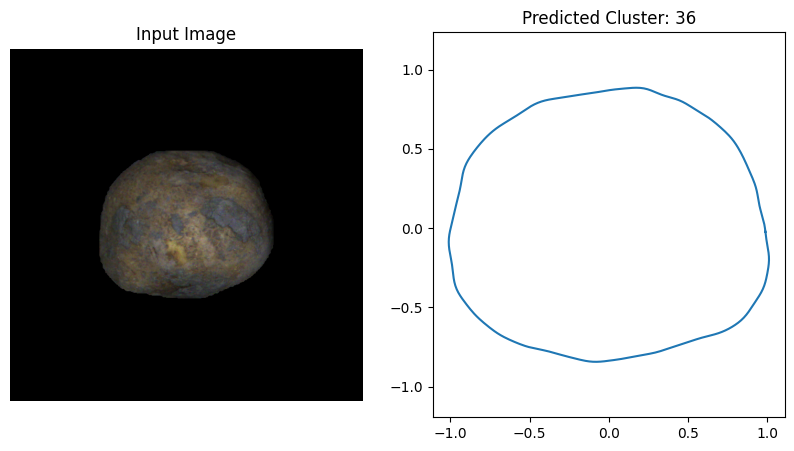

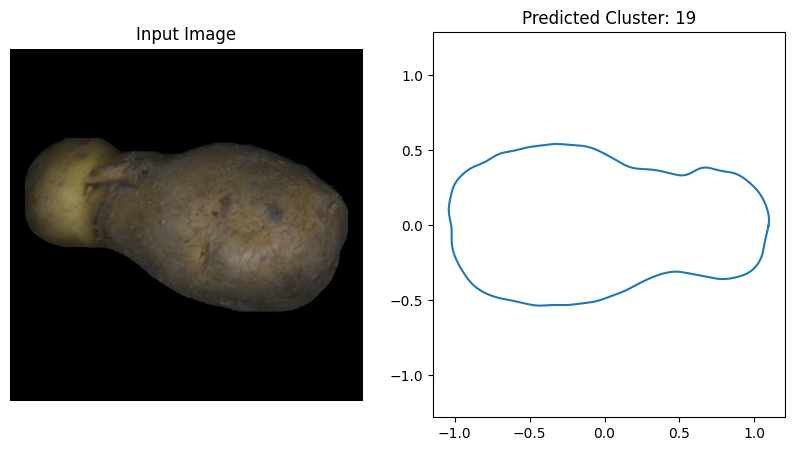

In [15]:

if __name__ == "__main__":
    folder_path = r"/Users/mishkat/Documents/malformed"
    # start = time.time()
    main(folder_path)